# IMPORT

In [1]:
from scipy.io import loadmat
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold


## Surf

In [2]:
#Amazon
A_surf = loadmat('surf/amazon.mat')
X_a_surf = A_surf['fts']
Y_a_surf = A_surf['labels']

#Caltech
C_surf = loadmat('surf/caltech10.mat')
X_c_surf = C_surf['fts']
Y_c_surf = C_surf['labels']

# Webcam
W_surf = loadmat('surf/webcam.mat')
X_w_surf = W_surf['fts']
Y_w_surf = W_surf['labels']

# Dslr
D_surf = loadmat('surf/dslr.mat')
X_d_surf = D_surf['fts']
Y_d_surf = D_surf['labels']


In [3]:
print(X_w_surf.shape)
print(Y_w_surf.shape)
print(X_d_surf.shape)
print(Y_d_surf.shape)

(295, 800)
(295, 1)
(157, 800)
(157, 1)


# Subspace Alignement

## Without optimal transport

In [4]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_w_surf, Y_w_surf.ravel())
print("The accuracy is "+str(knn.score(X_d_surf, Y_d_surf)*100)+"%")

The accuracy is 56.05095541401274%


/home/erick/Documents/otproject/envot/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/erick/Documents/otproject/envot/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


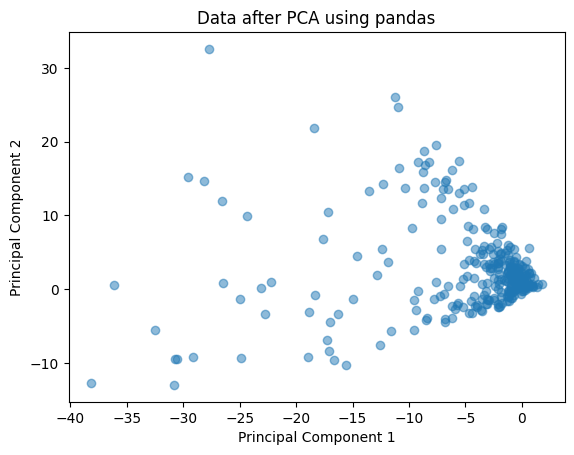

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(X_w_surf)
# Calculate the covariance matrix
cov_matrix = df.cov()

# Get the eigenvalues and eigenvectors
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

# Sort the eigenvectors by decreasing eigenvalues
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index]
sorted_eigenvectors = eigen_vectors[:, sorted_index]

# Transform the data
X_w_surf_pandas = np.dot(X_w_surf, sorted_eigenvectors)

# Visualize the transformed data
plt.scatter(X_w_surf_pandas[:, 0], X_w_surf_pandas[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data after PCA using pandas')
plt.show()


In [7]:
for i in range(len(sorted_eigenvalue)):
    sorted_eigenvalue[i]

In [8]:
np.sum(abs(sorted_eigenvalue)>0.0001)

294

## With optimal transport

In [18]:
def cross_val_subspace_get_d(S,S_y,T, T_y ):
    """ S is the source features, S_y is the source label, T is the target label, T_y is the target features"""
    #Normalization
    scaler = StandardScaler()
    S=scaler.fit_transform(S)
    T=scaler.fit_transform(T)
    list_score = []
    list_acc = []

    max_d=min([S.shape[0],S.shape[1],T.shape[0]])
    stf=KFold(5, shuffle=True, random_state=42)

    for d in range(1,max_d+1):
        pca = PCA(n_components=d, svd_solver='full')
        
        pca.fit(S)
        Xs=pca.components_.T
        
        pca.fit(T)
        Xt=pca.components_.T
        
        Xa=Xs@Xs.T@Xt
        Sa=S@Xa
        #St=T@Xt

        knn = KNeighborsClassifier(n_neighbors=1)
        #clf = fit.SVC(kernel='linear', C=1, random_state=42)
        scores = cross_val_score(knn, Sa, S_y.ravel(), cv=stf )
        avescore = np.average(scores)
        #print(f'd {d} and score {scores}')
        list_score.append(avescore)
        best_d = np.argmax(np.asarray(list_score))
    
    pca = PCA(n_components=best_d)
        
    pca.fit(S)
    Xs=pca.components_.T
    
    pca.fit(T)
    Xt=pca.components_.T
    
    Xa=Xs@Xs.T@Xt
    Sa=S@Xa
    St=T@Xt
    knn.fit(Sa,S_y.ravel())
    score_in_target = knn.score(St, T_y.ravel())
   
    return list_score, best_d, score_in_target





d 1 and score [0.25423729 0.15254237 0.20338983 0.22033898 0.16949153]
d 2 and score [0.37288136 0.28813559 0.23728814 0.38983051 0.3220339 ]
d 3 and score [0.49152542 0.52542373 0.37288136 0.50847458 0.47457627]
d 4 and score [0.50847458 0.61016949 0.50847458 0.61016949 0.6440678 ]
d 5 and score [0.6440678  0.71186441 0.57627119 0.74576271 0.76271186]
d 6 and score [0.6779661  0.76271186 0.66101695 0.79661017 0.77966102]
d 7 and score [0.71186441 0.76271186 0.66101695 0.83050847 0.81355932]
d 8 and score [0.72881356 0.79661017 0.71186441 0.77966102 0.79661017]
d 9 and score [0.72881356 0.83050847 0.83050847 0.77966102 0.86440678]
d 10 and score [0.81355932 0.83050847 0.81355932 0.79661017 0.86440678]
d 11 and score [0.79661017 0.83050847 0.81355932 0.81355932 0.86440678]
d 12 and score [0.83050847 0.83050847 0.83050847 0.79661017 0.86440678]
d 13 and score [0.81355932 0.86440678 0.79661017 0.79661017 0.83050847]
d 14 and score [0.79661017 0.84745763 0.79661017 0.79661017 0.84745763]
d

75

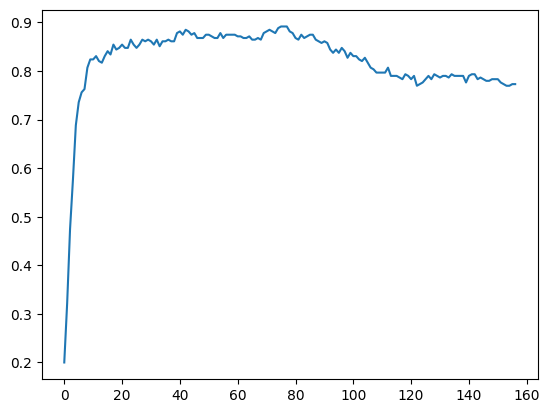

In [19]:
list_score, best_d, score_in_target = cross_val_subspace_get_d(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf)
plt.plot(list_score)
np.argmax(np.asarray(list_score))


In [22]:
score_in_target

0.9044585987261147

d 1 and score [0.25423729 0.15254237 0.20338983 0.22033898 0.16949153]
d 2 and score [0.37288136 0.28813559 0.23728814 0.38983051 0.3220339 ]
d 3 and score [0.49152542 0.52542373 0.37288136 0.50847458 0.47457627]
d 4 and score [0.50847458 0.61016949 0.50847458 0.61016949 0.6440678 ]
d 5 and score [0.6440678  0.71186441 0.57627119 0.74576271 0.76271186]
d 6 and score [0.6779661  0.76271186 0.66101695 0.79661017 0.77966102]
d 7 and score [0.71186441 0.76271186 0.66101695 0.83050847 0.81355932]
d 8 and score [0.72881356 0.79661017 0.71186441 0.77966102 0.79661017]
d 9 and score [0.72881356 0.83050847 0.83050847 0.77966102 0.86440678]
d 10 and score [0.81355932 0.83050847 0.81355932 0.79661017 0.86440678]
d 11 and score [0.79661017 0.83050847 0.81355932 0.81355932 0.86440678]
d 12 and score [0.83050847 0.83050847 0.83050847 0.79661017 0.86440678]
d 13 and score [0.81355932 0.86440678 0.79661017 0.79661017 0.83050847]
d 14 and score [0.79661017 0.84745763 0.79661017 0.79661017 0.84745763]
d

75

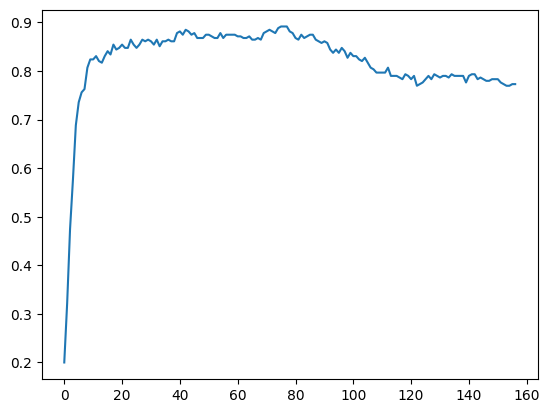

In [20]:
list_score, best_d, score_in_target = cross_val_subspace_get_d(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf)
plt.plot(list_score)
np.argmax(np.asarray(list_score))


In [90]:
#Normalization
print(X_w_surf.shape)
print(Y_w_surf.shape)
print(X_d_surf.shape)
print(Y_d_surf.shape)

scaler = StandardScaler()
S=scaler.fit_transform(X_w_surf)
T=scaler.fit_transform(X_d_surf)
list_score = []
list_acc = []
max_d=min([S.shape[0],S.shape[1],T.shape[0]])
stf=KFold(5, shuffle=True, random_state=42)
for d in range(1,max_d+1):
    pca = PCA(n_components=d)
    
    pca.fit(S)
    Xs=pca.components_.T
    
    pca.fit(T)
    Xt=pca.components_.T
    
    Xa=Xs@Xs.T@Xt
    Sa=S@Xa
    #St=T@Xt
    knn = KNeighborsClassifier(n_neighbors=1)
    #clf = fit.SVC(kernel='linear', C=1, random_state=42)
    scores = cross_val_score(knn, Sa, Y_w_surf.ravel(), cv=stf )
    avescore = np.average(scores)
    list_score.append(avescore)
    best_d = np.argmax(np.asarray(list_score))

pca = PCA(n_components=best_d)
    
pca.fit(S)
Xs=pca.components_.T

pca.fit(T)
Xt=pca.components_.T

Xa=Xs@Xs.T@Xt
Sa=S@Xa
St=T@Xt
knn.fit(Sa,Y_w_surf.ravel())
score_in_target = knn.score(St, Y_d_surf.ravel())

(295, 800)
(295, 1)
(157, 800)
(157, 1)


54

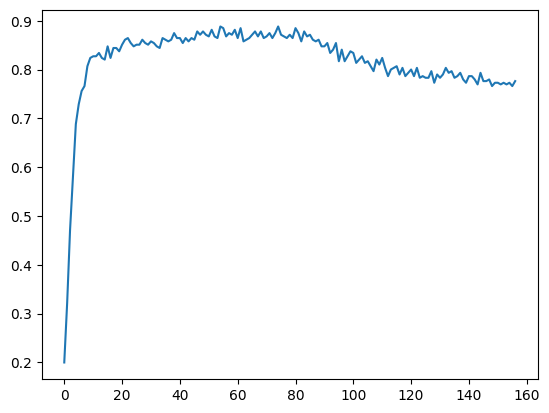

In [91]:
plt.plot(list_score)
np.argmax(np.asarray(list_score))

In [9]:


scaler = StandardScaler()
S=scaler.fit_transform(X_w_surf)
T=scaler.fit_transform(X_d_surf)
list_score = []
list_acc = []
max_d=min([S.shape[0],S.shape[1],T.shape[0]])
stf=KFold(5, shuffle=True, random_state=42)
for d in np.array([1,1,2,2]): #range(1,max_d+1):
    pca = PCA(n_components=d)
    
    pca.fit(S)
    Xs=pca.components_.T
    
    pca.fit(T)
    Xt=pca.components_.T
    
    Xa=Xs@Xs.T@Xt
    Sa=S@Xa
    #St=T@Xt
    knn = KNeighborsClassifier(n_neighbors=1)
    #clf = fit.SVC(kernel='linear', C=1, random_state=42)
    scores = cross_val_score(knn, Sa, Y_w_surf.ravel(), cv=stf )
    for i, (train_index, test_index) in enumerate(stf.split(Sa)):
        print(f"Fold {i}:")
        print(f"  Train: index={train_index}")
        print(f"  Test:  index={test_index}")
    print('SCORES',scores)
    avescore = np.average(scores)
    list_score.append(avescore)
    best_d = np.argmax(np.asarray(list_score))

pca = PCA(n_components=best_d)
    
pca.fit(S)
Xs=pca.components_.T

pca.fit(T)
Xt=pca.components_.T

Xa=Xs@Xs.T@Xt
Sa=S@Xa
St=T@Xt
knn.fit(Sa,Y_w_surf.ravel())
score_in_target = knn.score(St, Y_d_surf.ravel())

Fold 0:
  Train: index=[  0   1   2   3   4   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  23  26  27  28  29  31  32  34  35  36  37  38  39  40  41  43  44
  47  48  49  50  51  52  53  54  55  57  58  61  62  63  64  65  66  67
  68  69  70  71  72  74  75  76  78  79  80  81  83  85  86  87  88  89
  90  91  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 112 114 115 116 117 118 120 121 122 123 125 126 127 128 129 130 131
 133 134 135 136 137 138 139 141 142 145 146 147 149 150 151 153 154 156
 157 158 159 160 161 162 163 165 166 168 169 171 172 173 174 176 178 180
 181 183 184 185 187 188 189 190 191 192 194 195 196 198 199 200 201 203
 205 206 207 208 209 210 212 213 214 215 217 219 220 221 223 224 225 227
 229 230 231 232 233 234 235 237 239 240 241 242 243 244 246 247 248 249
 250 252 253 254 255 256 257 258 259 260 263 264 265 266 267 268 269 270
 271 272 274 275 276 277 279 280 282 283 285 286 287 288 289 290 291 292
 293 294]
  Test:  index=[  

In [10]:


scaler = StandardScaler()
S=scaler.fit_transform(X_w_surf)
T=scaler.fit_transform(X_d_surf)
list_score = []
list_acc = []
max_d=min([S.shape[0],S.shape[1],T.shape[0]])
stf=KFold(5, shuffle=True, random_state=42)
for d in np.array([1,1,2,2]): #range(1,max_d+1):
    pca = PCA(n_components=d)
    
    pca.fit(S)
    Xs=pca.components_.T
    
    pca.fit(T)
    Xt=pca.components_.T
    
    Xa=Xs@Xs.T@Xt
    Sa=S@Xa
    #St=T@Xt
    knn = KNeighborsClassifier(n_neighbors=1)
    #clf = fit.SVC(kernel='linear', C=1, random_state=42)
    scores = cross_val_score(knn, Sa, Y_w_surf.ravel(), cv=stf )
    for i, (train_index, test_index) in enumerate(stf.split(Sa)):
        print(f"Fold {i}:")
        print(f"  Train: index={train_index}")
        print(f"  Test:  index={test_index}")
    print('SCORES',scores)
    avescore = np.average(scores)
    list_score.append(avescore)
    best_d = np.argmax(np.asarray(list_score))

pca = PCA(n_components=best_d)
    
pca.fit(S)
Xs=pca.components_.T

pca.fit(T)
Xt=pca.components_.T

Xa=Xs@Xs.T@Xt
Sa=S@Xa
St=T@Xt
knn.fit(Sa,Y_w_surf.ravel())
score_in_target = knn.score(St, Y_d_surf.ravel())

Fold 0:
  Train: index=[  0   1   2   3   4   7   8  10  11  12  13  14  15  16  17  18  19  20
  21  23  26  27  28  29  31  32  34  35  36  37  38  39  40  41  43  44
  47  48  49  50  51  52  53  54  55  57  58  61  62  63  64  65  66  67
  68  69  70  71  72  74  75  76  78  79  80  81  83  85  86  87  88  89
  90  91  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 112 114 115 116 117 118 120 121 122 123 125 126 127 128 129 130 131
 133 134 135 136 137 138 139 141 142 145 146 147 149 150 151 153 154 156
 157 158 159 160 161 162 163 165 166 168 169 171 172 173 174 176 178 180
 181 183 184 185 187 188 189 190 191 192 194 195 196 198 199 200 201 203
 205 206 207 208 209 210 212 213 214 215 217 219 220 221 223 224 225 227
 229 230 231 232 233 234 235 237 239 240 241 242 243 244 246 247 248 249
 250 252 253 254 255 256 257 258 259 260 263 264 265 266 267 268 269 270
 271 272 274 275 276 277 279 280 282 283 285 286 287 288 289 290 291 292
 293 294]
  Test:  index=[  

36

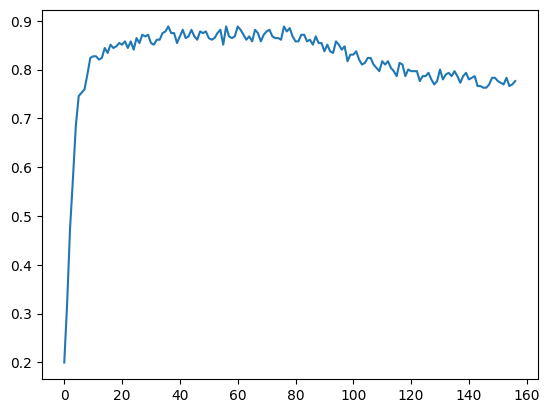

In [87]:
list_score, best_d, score_in_target = cross_val_subspace_get_d(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf)
plt.plot(list_score)
np.argmax(np.asarray(list_score))


68

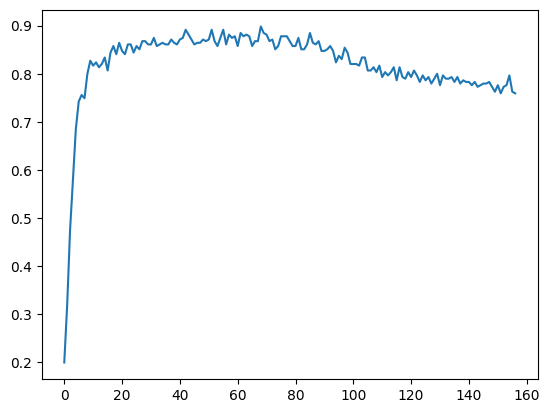

In [88]:
list_score, best_d, score_in_target = cross_val_subspace_get_d(X_w_surf,Y_w_surf,X_d_surf,Y_d_surf)
plt.plot(list_score)
np.argmax(np.asarray(list_score))

# Entropic regularized optimal transport

## Without optimal transport

## With optimal transport